## BME i9400
## Fall 2024
### Homework 5: Dropout regularization in MLPs and Convolutional Neural Networks

**Due date: Wednesday, December 11th 2024, 11:59 PM EST**

**Total points: 100**

## Instructions

In this homework you will familiarize yourself with a type of regularization that is commonly used in deep learning models: *dropout*.

Dropout is a regularization technique that aims to prevent overfitting by randomly “dropping out” (setting to zero) a subset of neurons and their connections during training. During each training iteration, a randomly selected subset of the neurons is temporarily removed from the network. By removing neurons, dropout forces the network to not rely too heavily on any one neuron, encouraging redundancy and robust feature learning.Note that during model evaluation, dropout is turned off, and all neurons are active, but their outputs are scaled by the dropout rate to maintain consistency with training.

Dropout mitigates overfitting by introducing noise into the training process, effectively training many smaller “sub-networks” and averaging their predictions. By training with multiple random sub-networks, the model becomes more robust and less sensitive to specific neurons or weights.

In PyTorch, dropout is implemented with the `nn.Dropout` module. The `nn.Dropout` module takes a single argument, `p`, which is the probability of dropping out a neuron. The `p` argument is the probability that a neuron will be zeroed out during training. The `p` argument is typically set to a value between 0.2 and 0.5.

To instantiate a dropout layer with a dropout rate of 0.2, you can use the following code:
```dropout_layer = nn.Dropout(p=0.2)```

To apply dropout to a tensor `x`, you can use the following code:
```x = dropout_layer(x)```


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

## Load the dataset, split into train and test sets, cast to PyTorch tensors, and create data loaders
(DONE FOR YOU)

In [2]:
tmp = np.load('../slides/eeg_alcohol_data.npy', allow_pickle=True)
X = tmp.item().get('X')
y = tmp.item().get('y')
if X.dtype != np.float32:
    X = np.array(X, dtype=np.float32)
if y.dtype not in [np.int32, np.int64]:
    y = np.array(y, dtype=np.int64)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Define the CNN model
We will work with a model that combines two convolutional layers at the front end with three fully connected layers at the back end. Pay attention to the arguments of the Conv2D and Linear blocks, as it will help your understanding of the model architecture.
(DONE FOR YOU)

In [3]:
class EEGCNN(nn.Module):
    def __init__(self, input_channels, input_timepoints, num_classes):
        super(EEGCNN, self).__init__()
        self.spatial_conv = nn.Conv2d(1, 8, kernel_size=(input_channels, 1))  # Spatial filtering
        self.temporal_conv = nn.Conv2d(8, 16, kernel_size=(1, 10), stride=(1, 2))  # Temporal filtering
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * ((input_timepoints - 10) // 2 + 1), 32) # fully connected layer 1
        self.fc2 = nn.Linear(32, 16)  # fully connected layer 2
        self.fc3 = nn.Linear(16, num_classes) # fully connected layer 3
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = torch.relu(self.spatial_conv(x))
        x = torch.relu(self.temporal_conv(x))
        x = self.flatten(x) # convert from 2D to 1D
        x = self.fc1(x) # fully connected layer 1
        x = self.fc2(x) # fully connected layer 2
        x = self.fc3(x) # fully connected layer 3
        x = self.softmax(x)

        return x

### Instantiate the model with the parameters of our dataset
(DONE FOR YOU)

In [4]:
input_channels = X_train.shape[1]  # 64 electrodes
input_timepoints = X_train.shape[2]  # 256 time samples
num_classes = len(torch.unique(y_train))  # Number of unique classes in y
model = EEGCNN(input_channels, input_timepoints, num_classes)

### Define the training loop and train for 200 epochs
Below is a function that trains the model for a specified number of epochs, reporting the training and test loss after each epoch.
(DONE FOR YOU)

In [5]:
def run_train_loop(model, criterion, optimizer, epochs=200):

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # evaluate test loss
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                test_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Test Loss: {test_loss/len(test_loader):.4f}")
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

    return train_losses, test_losses

### Here we train the model for 200 epochs
(DONE FOR YOU)

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 200
train_losses, test_losses = run_train_loop(model, criterion, optimizer, epochs)

Epoch 1/200, Loss: 0.6743, Test Loss: 0.6947
Epoch 2/200, Loss: 0.5885, Test Loss: 0.6079
Epoch 3/200, Loss: 0.5208, Test Loss: 0.6022
Epoch 4/200, Loss: 0.4705, Test Loss: 0.6440
Epoch 5/200, Loss: 0.4487, Test Loss: 0.6117
Epoch 6/200, Loss: 0.4213, Test Loss: 0.5764
Epoch 7/200, Loss: 0.3927, Test Loss: 0.5486
Epoch 8/200, Loss: 0.3696, Test Loss: 0.5824
Epoch 9/200, Loss: 0.3452, Test Loss: 0.5997
Epoch 10/200, Loss: 0.3300, Test Loss: 0.5721
Epoch 11/200, Loss: 0.3240, Test Loss: 0.5868
Epoch 12/200, Loss: 0.3256, Test Loss: 0.5744
Epoch 13/200, Loss: 0.3308, Test Loss: 0.5836
Epoch 14/200, Loss: 0.3291, Test Loss: 0.5668
Epoch 15/200, Loss: 0.3258, Test Loss: 0.5665
Epoch 16/200, Loss: 0.3256, Test Loss: 0.5757
Epoch 17/200, Loss: 0.3238, Test Loss: 0.5748
Epoch 18/200, Loss: 0.3233, Test Loss: 0.5790
Epoch 19/200, Loss: 0.3218, Test Loss: 0.5912
Epoch 20/200, Loss: 0.3214, Test Loss: 0.5661
Epoch 21/200, Loss: 0.3213, Test Loss: 0.5654
Epoch 22/200, Loss: 0.3224, Test Loss: 0.56

## Task 1: Plot the training and test loss (overlaid) on the vertical axis and the epoch number on the horizontal axis

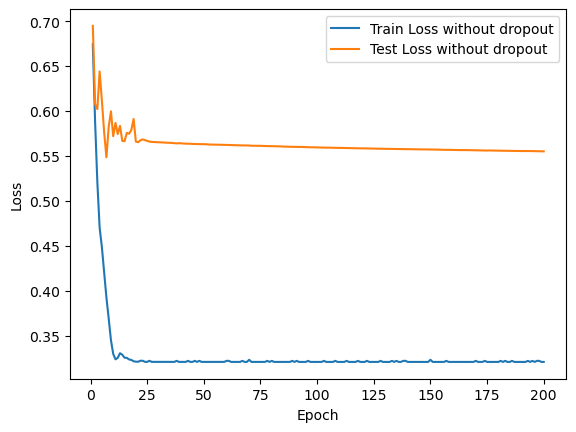

In [7]:
## INSERT CODE HERE
# Plot the training and test loss (overlaid) on the vertical axis and the epoch number on the horizontal axis
plt.plot(range(1, epochs+1), train_losses, label='Train Loss without dropout')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss without dropout')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Task 2: Compute the minimum train and test loss achieved during training and report them

In [8]:
## INSERT CODE HERE
# Compute the minimum train and test loss achieved during training and report them
min_train_loss = min(train_losses)
min_test_loss = min(test_losses)
print(f"Minimum train loss without dropout: {min_train_loss:.4f}")
print(f"Minimum test loss without dropout: {min_test_loss:.4f}")

Minimum train loss without dropout: 0.3211
Minimum test loss without dropout: 0.5486


## Task 3: Modify EEGCNN to add dropout regularization
- Modify the cell below to add **three** dropout layers to the EEGCNN model
    - The first dropout layer should be added after the flattening layer
    - The second dropout layer should be added after the first fully connected layer
    - The third dropout layer should be added after the second fully connected layer
- The dropout rates of each layer should be the same and should be passed as an argument to the model constructor
- The default dropout rate should be 0.2

In [9]:
class EEGCNNwithDropout(nn.Module):
    def __init__(self, input_channels, input_timepoints, num_classes, dropout=0.2):
        super(EEGCNNwithDropout, self).__init__()
        self.spatial_conv = nn.Conv2d(1, 8, kernel_size=(input_channels, 1))
        self.temporal_conv = nn.Conv2d(8, 16, kernel_size=(1, 10), stride=(1, 2))
        self.flatten = nn.Flatten()
        self.dropout_layer1 = nn.Dropout(p=dropout)
        self.fc1 = nn.Linear(16 * ((input_timepoints - 10) // 2 + 1), 32)
        self.dropout_layer2 = nn.Dropout(p=dropout)
        self.fc2 = nn.Linear(32, 16)
        self.dropout_layer3 = nn.Dropout(p=dropout)
        self.fc3 = nn.Linear(16, num_classes)
        self.softmax = nn.Softmax(dim=1)
        # INSERT CODE BELOW

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = torch.relu(self.spatial_conv(x))
        x = torch.relu(self.temporal_conv(x))
        x = self.flatten(x)
        x = self.dropout_layer1(x)
        # INSERT CODE BELOW
        x = self.fc1(x)
        x = self.dropout_layer2(x)
        x = self.fc2(x)
        x = self.dropout_layer3(x)
        x = self.fc3(x)
        x = self.softmax(x)

        return x

## Task 4: Train the EEGCNNwithDropout model with a dropout rate of 0.2 for 200 epochs
- Instantiate the model with a dropout rate of 0.2
- Train the model for 200 epochs

In [10]:
## INSERT CODE BELOW
# Instantiate the model with a dropout rate of 0.2
model = EEGCNNwithDropout(input_channels, input_timepoints, num_classes, dropout=0.2)
## DO NOT MODIFY THE 3 LINES BELOW
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses, test_losses = run_train_loop(model, criterion, optimizer, 200)

Epoch 1/200, Loss: 0.7349, Test Loss: 0.6776
Epoch 2/200, Loss: 0.6152, Test Loss: 0.6398
Epoch 3/200, Loss: 0.5445, Test Loss: 0.5704
Epoch 4/200, Loss: 0.4953, Test Loss: 0.5782
Epoch 5/200, Loss: 0.4660, Test Loss: 0.5442
Epoch 6/200, Loss: 0.4386, Test Loss: 0.5169
Epoch 7/200, Loss: 0.4229, Test Loss: 0.5368
Epoch 8/200, Loss: 0.3958, Test Loss: 0.5224
Epoch 9/200, Loss: 0.3823, Test Loss: 0.5286
Epoch 10/200, Loss: 0.3823, Test Loss: 0.5535
Epoch 11/200, Loss: 0.3727, Test Loss: 0.5647
Epoch 12/200, Loss: 0.3634, Test Loss: 0.5425
Epoch 13/200, Loss: 0.3501, Test Loss: 0.5343
Epoch 14/200, Loss: 0.3525, Test Loss: 0.5632
Epoch 15/200, Loss: 0.3472, Test Loss: 0.5657
Epoch 16/200, Loss: 0.3411, Test Loss: 0.5504
Epoch 17/200, Loss: 0.3418, Test Loss: 0.5565
Epoch 18/200, Loss: 0.3389, Test Loss: 0.5379
Epoch 19/200, Loss: 0.3377, Test Loss: 0.5372
Epoch 20/200, Loss: 0.3499, Test Loss: 0.6015
Epoch 21/200, Loss: 0.3734, Test Loss: 0.4897
Epoch 22/200, Loss: 0.3625, Test Loss: 0.51

## Task 5: Plot the training and test loss (overlaid) on the vertical axis and the epoch number on the horizontal axis

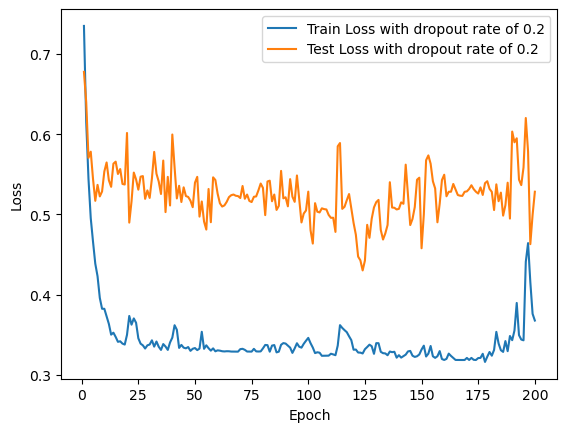

In [11]:
# INSERT CODE HERE
# Plot the training and test loss (overlaid) on the vertical axis and the epoch number on the horizontal axis
plt.plot(range(1, epochs+1), train_losses, label='Train Loss with dropout rate of 0.2')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss with dropout rate of 0.2')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Task 6: Compute the minimum train and test loss achieved during training and report them

In [12]:
# INSERT CODE HERE
# Compute the minimum train and test loss achieved during training and report them
min_train_loss = min(train_losses)
min_test_loss = min(test_losses)
print(f"Minimum train loss with dropout rate of 0.2: {min_train_loss:.4f}")
print(f"Minimum test loss with dropout rate of 0.2: {min_test_loss:.4f}")

Minimum train loss with dropout rate of 0.2: 0.3161
Minimum test loss with dropout rate of 0.2: 0.4301


## Task 7: Train the EEGCNNwithDropout model with a dropout rate of 0.5 for 200 epochs

In [13]:
## INSERT CODE BELOW
# Instantiate the model with a dropout rate of 0.2
model = EEGCNNwithDropout(input_channels, input_timepoints, num_classes, dropout=0.5)
## DO NOT MODIFY THE 3 LINES BELOW
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses, test_losses = run_train_loop(model, criterion, optimizer, 200)

Epoch 1/200, Loss: 0.7065, Test Loss: 0.6698
Epoch 2/200, Loss: 0.6296, Test Loss: 0.6365
Epoch 3/200, Loss: 0.5706, Test Loss: 0.5706
Epoch 4/200, Loss: 0.5268, Test Loss: 0.5835
Epoch 5/200, Loss: 0.4807, Test Loss: 0.5638
Epoch 6/200, Loss: 0.4873, Test Loss: 0.5433
Epoch 7/200, Loss: 0.4621, Test Loss: 0.5790
Epoch 8/200, Loss: 0.4647, Test Loss: 0.5629
Epoch 9/200, Loss: 0.4450, Test Loss: 0.5649
Epoch 10/200, Loss: 0.4288, Test Loss: 0.5309
Epoch 11/200, Loss: 0.4221, Test Loss: 0.5413
Epoch 12/200, Loss: 0.4333, Test Loss: 0.5563
Epoch 13/200, Loss: 0.4264, Test Loss: 0.5578
Epoch 14/200, Loss: 0.3973, Test Loss: 0.5108
Epoch 15/200, Loss: 0.3914, Test Loss: 0.5011
Epoch 16/200, Loss: 0.3883, Test Loss: 0.5171
Epoch 17/200, Loss: 0.3768, Test Loss: 0.5252
Epoch 18/200, Loss: 0.3677, Test Loss: 0.5587
Epoch 19/200, Loss: 0.3833, Test Loss: 0.5191
Epoch 20/200, Loss: 0.3943, Test Loss: 0.5362
Epoch 21/200, Loss: 0.3823, Test Loss: 0.5599
Epoch 22/200, Loss: 0.3921, Test Loss: 0.54

## Task 8: Plot the training and test loss (overlaid) on the vertical axis and the epoch number on the horizontal axis

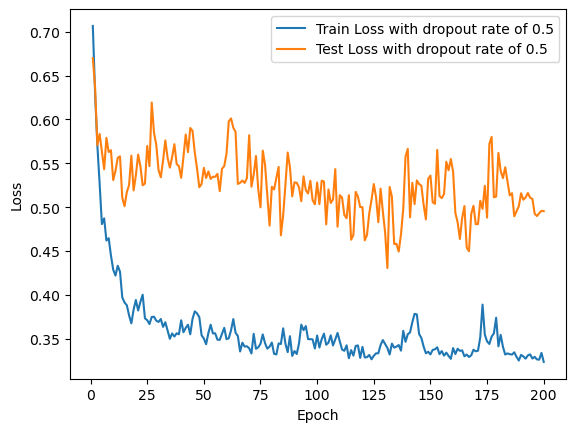

In [14]:
# INSERT CODE HERE
# Plot the training and test loss (overlaid) on the vertical axis and the epoch number on the horizontal axis
plt.plot(range(1, epochs+1), train_losses, label='Train Loss with dropout rate of 0.5')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss with dropout rate of 0.5')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Task 9: Compute the minimum train and test loss achieved during training and report them

In [15]:
# INSERT CODE HERE
# Compute the minimum train and test loss achieved during training and report them
min_train_loss = min(train_losses)
min_test_loss = min(test_losses)
print(f"Minimum train loss with dropout rate of 0.5: {min_train_loss:.4f}")
print(f"Minimum test loss with dropout rate of 0.5: {min_test_loss:.4f}")

Minimum train loss with dropout rate of 0.5: 0.3238
Minimum test loss with dropout rate of 0.5: 0.4307


## Task 10: Repeat Tasks 7-9 for a dropout rate of 0.8
Report your observations. What do you notice about the train and test loss as the dropout rate increases?

In [16]:
## INSERT CODE BELOW
# Instantiate the model with a dropout rate of 0.8
model = EEGCNNwithDropout(input_channels, input_timepoints, num_classes, dropout=0.8)
## DO NOT MODIFY THE 3 LINES BELOW
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses, test_losses = run_train_loop(model, criterion, optimizer, 200)

Epoch 1/200, Loss: 0.7349, Test Loss: 0.7421
Epoch 2/200, Loss: 0.7530, Test Loss: 0.7462
Epoch 3/200, Loss: 0.7767, Test Loss: 0.7281
Epoch 4/200, Loss: 0.7447, Test Loss: 0.7128
Epoch 5/200, Loss: 0.7523, Test Loss: 0.7166
Epoch 6/200, Loss: 0.7546, Test Loss: 0.7216
Epoch 7/200, Loss: 0.7349, Test Loss: 0.7162
Epoch 8/200, Loss: 0.7388, Test Loss: 0.7061
Epoch 9/200, Loss: 0.7364, Test Loss: 0.6921
Epoch 10/200, Loss: 0.7199, Test Loss: 0.6991
Epoch 11/200, Loss: 0.6856, Test Loss: 0.7079
Epoch 12/200, Loss: 0.6835, Test Loss: 0.7068
Epoch 13/200, Loss: 0.6765, Test Loss: 0.6998
Epoch 14/200, Loss: 0.6524, Test Loss: 0.6864
Epoch 15/200, Loss: 0.6586, Test Loss: 0.6672
Epoch 16/200, Loss: 0.6416, Test Loss: 0.6547
Epoch 17/200, Loss: 0.6482, Test Loss: 0.6494
Epoch 18/200, Loss: 0.6327, Test Loss: 0.6431
Epoch 19/200, Loss: 0.6130, Test Loss: 0.6413
Epoch 20/200, Loss: 0.6277, Test Loss: 0.6221
Epoch 21/200, Loss: 0.6103, Test Loss: 0.6136
Epoch 22/200, Loss: 0.5844, Test Loss: 0.63

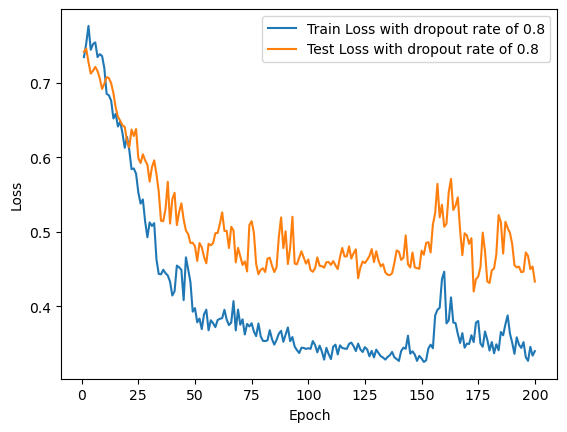

In [17]:
# Plot the training and test loss (overlaid) on the vertical axis and the epoch number on the horizontal axis
plt.plot(range(1, epochs+1), train_losses, label='Train Loss with dropout rate of 0.8')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss with dropout rate of 0.8')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
# Compute the minimum train and test loss achieved during training and report them
min_train_loss = min(train_losses)
min_test_loss = min(test_losses)
print(f"Minimum train loss with dropout rate of 0.8: {min_train_loss:.4f}")
print(f"Minimum test loss with dropout rate of 0.8: {min_test_loss:.4f}")

Minimum train loss with dropout rate of 0.8: 0.3254
Minimum test loss with dropout rate of 0.8: 0.4200


# Observations
- As the dropout rate increases, the minimum train and test loss decreases until a dropout rate beyond which both losses will increase.

- A dropout rate of 0.2 seems to be optimal for this dataset, as it achieves the lowest train and test loss.
- A dropout rate of 0.8 is too high, as it results in the both losses increasing.